In this notebook, we benchmark ControlNet vs ControlNet-XS on StableDiffuxion-XL.

**Result:** ControlNet-XS is around **20% faster** than ControlNet, while being 90% smaller and roughly the same quality.

Author: [UmerHA](https://x.com/UmerHAdil)

### Setup

In [1]:
from diffusers import ControlNetModel, ControlNetXSModel, StableDiffusionXLControlNetPipeline, StableDiffusionXLControlNetXSPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2

In [2]:
def image_grid(imgs, rows, cols, resize_to=300):
    assert len(imgs) == rows * cols

    if resize_to is not None:
        imgs = [img.resize((resize_to,resize_to)) for img in imgs]

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [3]:
def make_canny(img):
    img = np.array(img)
    img = cv2.Canny(img, 100, 200)
    img = img[:, :, None]
    img = np.concatenate([img, img, img], axis=2)
    return Image.fromarray(img)

In [4]:
prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = "low quality, bad quality, sketches"

image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png")
canny_image = make_canny(image)

In [5]:
num_images = 10

In [6]:
import time

class Timer:
    def start(self):
        self.start_time = time.time()
        return self
    
    def stop(self):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time
        print(f"Execution time: {self.execution_time:.0f} seconds")

___

### ControlNet

In [7]:
controlnet_conditioning_scale = 0.7

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
def generate_one_image(seed):
    generator = torch.Generator(device="cuda").manual_seed(seed)
    return pipe(
        prompt, negative_prompt=negative_prompt, image=image, controlnet_conditioning_scale=controlnet_conditioning_scale, generator=generator
    ).images[0]

In [9]:
timer = Timer().start()

# sequentially generate single images
images = [generate_one_image(seed) for seed in range(num_images)]

timer.stop()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Execution time: 198 seconds


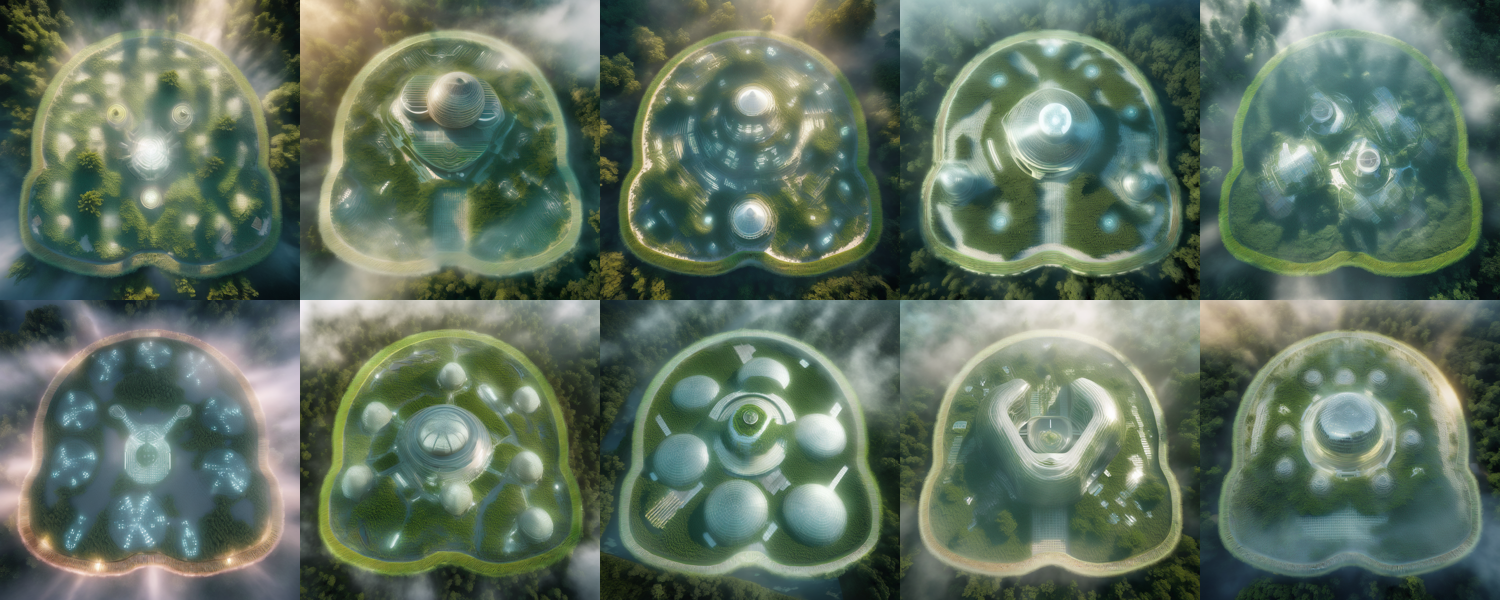

In [10]:
image_grid(images, 2, 5)

In [11]:
del controlnet, vae, pipe

---

### ControlNet-XS

In [12]:
controlnet_conditioning_scale = 0.7

controlnet = ControlNetXSModel.from_pretrained(
    "UmerHA/ConrolNetXS-SDXL-canny",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetXSPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
def generate_one_image(seed):
    generator = torch.Generator(device="cuda").manual_seed(seed)
    return pipe(
        prompt, negative_prompt=negative_prompt, image=image, controlnet_conditioning_scale=controlnet_conditioning_scale, generator=generator
    ).images[0]

In [14]:
timer_xs = Timer().start()

# sequentially generate single images
images = [generate_one_image(seed) for seed in range(num_images)]

timer_xs.stop()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Execution time: 151 seconds


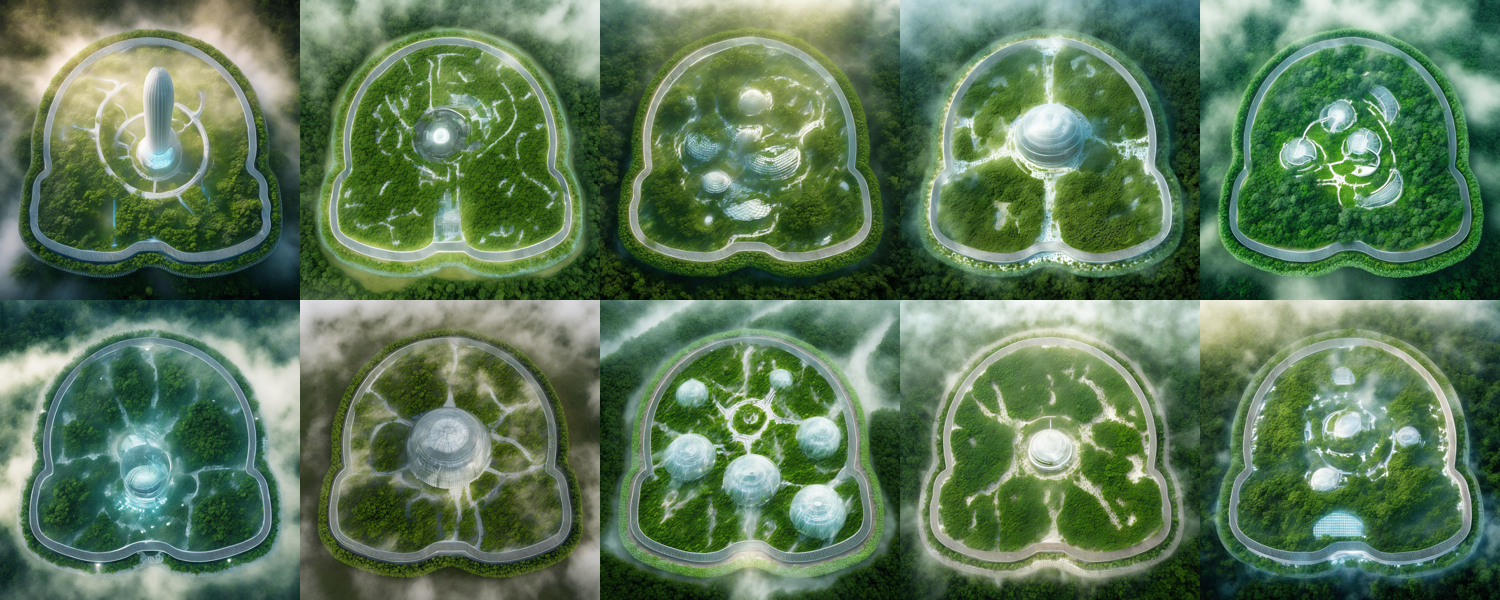

In [15]:
image_grid(images, 2, 5)

___

In [17]:
speedup = 1 - timer_xs.execution_time/timer.execution_time
print(f"Speedup of {100*speedup:.1f}%")

Speedup of 23.9%
